# Reconnaissance des Emotions - 2/2

## - Détection des visages dans l'image

## - Interface de reconnaissance des émotions sur un flux streaming (webcam)

<hr>

- <a href='#1'>Implémentation d'un modèle de détection des visages : utilisation de MTCNN</a>
- <a href='#2'>Reconnaissance de l'expression faciale sur une image (MTCNN)</a>
- <a href='#3'>Reconnaissance de l'expression faciale sur un flux vidéo avec MTCNN</a>

<hr>

In [1]:
import os
import sys
import numpy as np
import cv2
from pprint import pprint

import matplotlib.pyplot as plt

from tensorflow.keras import models
from mtcnn_cv2 import MTCNN

### <a id='1'>Implémentation d'un modèle de détection des visages : utilisation de MTCNN</a>

###### Réseau convolutif en cascade multi-tâches MTCNN

MTCNN est une alternative interessante à HaarCascade, qui présente l'avantage d'être une bibliothèque python et donc d'être installable rapidement par pip (`pip install mtcnn`).

Après avoir fait un premier essai avec HaarCascade, j'ai choisi le modèle MTCNN est plus précis et plus complet que HaarCascade sur la reconnaissance des visages, ce qui évite les "décrochages" lors des traitements qui sont effectués par la suite sur l'image. Il semble cependant qu'il ne soit pas aussi rapide que HaarCascade, donc peut-être moins adapté au flux streaming... Cependant les résultats obtenus avec notre modèle utilisant MTCNN étant meilleurs que le ceux du modèle utilisant HaarCascade, c'est le premier que nous présenterons dans ce notebook.

Le module [MTCNN de base](https://pypi.org/project/mtcnn/) n'étant pas compatible avec OpenCV (cv2) que nous allons utiliser pour lire le flux streaming, nous allons ici utiliser [MTCNN-OpenCV](https://pypi.org/project/mtcnn-opencv/)

In [2]:
!pip install mtcnn-opencv 

###### Découverte du fonctionnement de MTCNN

In [3]:
from mtcnn_cv2 import MTCNN

In [4]:
detector = MTCNN()

[{'box': [426, 115, 40, 51],
  'confidence': 0.9999743700027466,
  'keypoints': {'left_eye': (437, 135),
                'mouth_left': (439, 153),
                'mouth_right': (457, 152),
                'nose': (448, 146),
                'right_eye': (456, 133)}},
 {'box': [213, 16, 44, 53],
  'confidence': 0.9558693170547485,
  'keypoints': {'left_eye': (225, 32),
                'mouth_left': (227, 55),
                'mouth_right': (244, 54),
                'nose': (233, 44),
                'right_eye': (245, 31)}}]


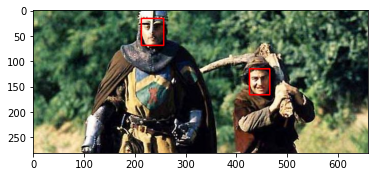

In [5]:
img = cv2.imread("pictures/visiteurs4.png", 3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rois = detector.detect_faces(img)

for roi in rois:
    (x,y,w,h) = roi['box']
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(img) 
plt.imshow(img)
pprint(rois)

MTCNN retourne une liste des ROI (regions of interest) - une par visage -  dans l'image. <br>

Chaque ROI est décrite sous la forme d'un dictionnaire ayant pour clés :
 - la bounding box correspondant à l'encadrement d'un visage
 - un indice de confiance
 - les points clés de l'image (yeux/nez/bouche). 

Nous n'utiliserons pas ces derniers dans la suite, par contre les coordonnées de la bounding-box nous seront utiles. Elles nous permettront d'extraire la zone à analyser pour la reconnaissance de l'expression faciale, et d'encadrer le visage reconnu dans l'image interfacée.

###### Comparaison avec HaarCascade

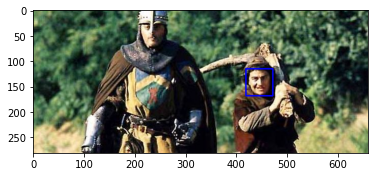

In [6]:
detec_visage_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.imread("pictures/visiteurs4.png", 3)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

visage = detec_visage_model.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in visage:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img) 

Pour la même image, le classifieur HaarCascade Frontalface Defaut n'a pas reconnu le protagoniste portant un casque, contrairement à MTCNN. Bien sûr il existe d'autre modèles de classifieurs Haarcascade qui pourraient permettre d'obtenir une deuxième ROI, mais MTCNN présente l'avantage d'être complet et simple d'utilisation.

### <a id='2'>Reconnaissance de l'expression faciale sur une image</a>

In [7]:
# Chargement des modèles
recognator = models.load_model('modelX_76')
detector = MTCNN()

In [8]:
# on recupère les labels et le nombre de classes comme dans le notebook précédent
tmp = os.listdir("./images/data/train")
LABELS ={}
for clas, feeling in enumerate(tmp):
    LABELS[clas]=feeling
NUM_CLASS = len(tmp)

In [9]:
# création de la fonction de locatisation des visages
def localize_face(file):
    image = cv2.imread(file, 3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rois = detector.detect_faces(image)
    localized = []
    boxes = []
    for roi in rois: # pour chaque visage détecté
        x, y, w, h = roi['box'] # on récupère les coordonnées de la bounding box
        cropped = image[y-10:y+h+10, x-10:x+w+10] # on rogne l'image autour de la bbox en gardant une marge de 10px
        
        # on formate l'image pour qu'elle puisse être traîtée par le modèle de reconaissance de l'émotion :
        # noir et blanx, 48x48px :
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        resized = (cv2.resize(gray,(48,48)).astype('float') / 255).reshape(1,48,48,1) 
        
        localized.append(resized)
        boxes.append([x, y, w, h])
    return image, localized, boxes

In [10]:
# création de la fonction de reconnaissance de l'émotion 
def recognise_emotion(image, faces, boxes):
    emotions=[]
    for i in range(len(faces)) : # pour chaque couple (bbox, visage)
        emotion = np.argmax(recognator.predict(faces[i])) # reconaissance de l'émotion
        x, y, w, h = boxes[i] # récupération des coordonnées de la bbox pour tracer le rectangle
        image = cv2.rectangle(image,(x-10,y-10),(x+w+10,y+h+10),(255,255,0),2) # on trace le rectangle
        plt.text(x+2, y-16, LABELS[emotion], color="#00ff55", fontsize=14) # on annote l'image
        emotions.append(LABELS[emotion])
    plt.axis("off")
    plt.imshow(image)
    return emotions

['happy', 'happy']

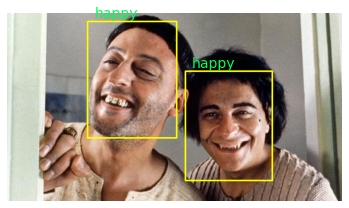

In [11]:
image, localized_faces, boxes = localize_face("pictures/visiteurs.png")
recognise_emotion(image, localized_faces, boxes)

['sad', 'angry']

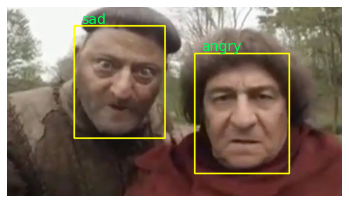

In [12]:
image, localized_faces, boxes = localize_face('pictures/visiteurs2.png')
recognise_emotion(image, localized_faces, boxes)

['surprise']

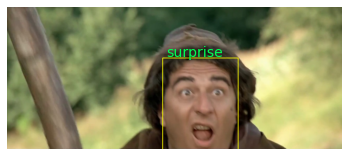

In [13]:
image, localized_faces, boxes = localize_face('pictures/visiteurs3.png')
recognise_emotion(image, localized_faces, boxes)

### <a id='1'>Reconnaissance de l'expression faciale sur un flux vidéo avec MTCNN</a>

In [14]:
# chargement des modèles
recognator = models.load_model('modelX_76')
detector = MTCNN()

In [15]:
# on recupère les labels et le nombre de classes
tmp = os.listdir("./images/data/train")
LABELS ={}
for clas, feeling in enumerate(tmp):
    LABELS[clas]=feeling
NUM_CLASS = len(tmp)

# chargement des emojis
EMOJI = {0: cv2.imread('emojis/0-angry.png'),
 1: cv2.imread('emojis/1-disgust.png'),
 2: cv2.imread('emojis/2-fear.png'),
 3: cv2.imread('emojis/3-happy.png'),
 4: cv2.imread('emojis/4-neutral.png'),
 5: cv2.imread('emojis/5-sad.png'),
 6: cv2.imread('emojis/6-surprise.png')}

# chargement des sons

import simpleaudio as sa

SOUND = {0: sa.WaveObject.from_wave_file('sons/angry.wav'),
 1: sa.WaveObject.from_wave_file('sons/disgust.wav'),
 2: sa.WaveObject.from_wave_file('sons/fear.wav'),
 3: sa.WaveObject.from_wave_file('sons/happy.wav'),
 4: sa.WaveObject.from_wave_file('sons/neutral.wav'),
 5: sa.WaveObject.from_wave_file('sons/sad.wav'),
 6: sa.WaveObject.from_wave_file('sons/surprise.wav')}

In [16]:
# fonction de locatisation des visages - modifications pour utilisation avec flux video filmant 1 seule personne
def localize_face(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    x, y, w, h = detector.detect_faces(image)[0]['box']
    while detector.detect_faces(image)[0]['confidence']>0.6 :
        cropped = image[y-10:y+h+10, x-10:x+w+10]
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray,(48,48)).astype('float') / 255
        localized = resized.reshape(1,48,48,1)
        return localized, [x, y, w, h]

In [17]:
class AudioPlayer:
    def __init__(self):
        self.play_obj = None

    def play(self, son):
        wave_obj = son
        self.play_obj = wave_obj.play()
    
    def is_done(self):
        if self.play_obj:
            return not self.play_obj.is_playing()
        return True

In [18]:
def detection_emotion():
    player = AudioPlayer()
    cam = cv2.VideoCapture(0)
    while True:
        ret_val, frame = cam.read()

        # localisation des visages dans l'image
        face, box = localize_face(frame)
        
        # reconnaissance de l'émotion
        emotion = np.argmax(recognator.predict(face))

        # creation d'une ROI pour l'affichage du smiley
        rows,cols,channels = EMOJI[0].shape
        roi_smiley = frame[0:rows, 0:cols]

        # Selon le résultat de la prédiction
        frame[0:rows, 0:cols ] = EMOJI[emotion]
        if player.is_done():
            player.play(SOUND[emotion])

        frame = cv2.flip(frame, 1)# retourne l'image pour l'afficer en miroir
        
        # affichage de l'image
        cv2.imshow('How are you ?', frame)
        
        # pour quitter, appui sur la touche ESC
        if cv2.waitKey(1) == 27: 
            break 
    cam.release()
    cv2.destroyAllWindows()

In [19]:
detection_emotion()